In [1]:
import cv2
import os, sys, gc
import time
import numpy as np
import mediapipe as mp
from tqdm.auto import tqdm
import multiprocessing
from joblib import Parallel, delayed
from natsort import natsorted
from glob import glob
import math
import pickle
import torch
from IPython.display import display, clear_output
from PIL import Image
import io
import shutil
import matplotlib.pyplot as plt

In [2]:
mp_holistic = mp.solutions.holistic

N_FACE_LANDMARKS = 468
N_BODY_LANDMARKS = 33
N_HAND_LANDMARKS = 21

In [3]:
class Counter(object):
    # https://stackoverflow.com/a/47562583/
    def __init__(self, initval=0):
        self.val = multiprocessing.RawValue("i", initval)
        self.lock = multiprocessing.Lock()

    def increment(self):
        with self.lock:
            self.val.value += 1

    @property
    def value(self):
        return self.val.value

In [4]:
def process_body_landmarks(component, n_points):
    kps = np.zeros((n_points, 3))
    conf = np.zeros(n_points)
    if component is not None:
        landmarks = component.landmark
        kps = np.array([[p.x, p.y, p.z] for p in landmarks])
        conf = np.array([p.visibility for p in landmarks])
    return kps, conf

In [5]:
def process_other_landmarks(component, n_points):
    kps = np.zeros((n_points, 3))
    conf = np.zeros(n_points)
    if component is not None:
        landmarks = component.landmark
        kps = np.array([[p.x, p.y, p.z] for p in landmarks])
        conf = np.ones(n_points)
    return kps, conf

In [6]:
def get_holistic_keypoints(
    frames, holistic=mp_holistic.Holistic(static_image_mode=False, model_complexity=2)
):
    """
    For videos, it's optimal to create with `static_image_mode=False` for each video.
    https://google.github.io/mediapipe/solutions/holistic.html#static_image_mode
    """

    keypoints = []
    confs = []

    for frame in frames:
        results = holistic.process(frame)

        body_data, body_conf = process_body_landmarks(
            results.pose_landmarks, N_BODY_LANDMARKS
        )
        face_data, face_conf = process_other_landmarks(
            results.face_landmarks, N_FACE_LANDMARKS
        )
        lh_data, lh_conf = process_other_landmarks(
            results.left_hand_landmarks, N_HAND_LANDMARKS
        )
        rh_data, rh_conf = process_other_landmarks(
            results.right_hand_landmarks, N_HAND_LANDMARKS
        )

        data = np.concatenate([body_data, face_data, lh_data, rh_data])
        conf = np.concatenate([body_conf, face_conf, lh_conf, rh_conf])

        keypoints.append(data)
        confs.append(conf)

    # TODO: Reuse the same object when this issue is fixed: https://github.com/google/mediapipe/issues/2152
    holistic.reset()
    del holistic
    gc.collect()

    keypoints = np.stack(keypoints)
    confs = np.stack(confs)
    return keypoints, confs


In [7]:
def gen_keypoints_for_frames(frames, save_path):

    pose_kps, pose_confs = get_holistic_keypoints(frames)
    body_kps = np.concatenate([pose_kps[:, :33, :], pose_kps[:, 501:, :]], axis=1)

    confs = np.concatenate([pose_confs[:, :33], pose_confs[:, 501:]], axis=1)

    d = {"keypoints": body_kps, "confidences": confs}

    with open(save_path + ".pkl", "wb") as f:
        pickle.dump(d, f, protocol=4)

In [8]:
def load_frames_from_video(video_path):
    frames = []
    vidcap = cv2.VideoCapture(video_path)
    while vidcap.isOpened():
        success, img = vidcap.read()
        if not success:
            break
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        # img = cv2.resize(img, (640, 480))
        frames.append(img)

    vidcap.release()
    # cv2.destroyAllWindows()
    return np.asarray(frames)

In [9]:
def load_frames_from_folder(frames_folder, patterns=["*.jpg"]):
    images = []
    for pattern in patterns:
        images.extend(glob(f"{frames_folder}/{pattern}"))
    images = natsorted(list(set(images)))  # remove dupes
    if not images:
        exit(f"ERROR: No frames in folder: {frames_folder}")

    frames = []
    for img_path in images:
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        frames.append(img)

    return np.asarray(frames)

In [10]:
def gen_keypoints_for_video(video_path, save_path):
    if not os.path.isfile(video_path):
        print("SKIPPING MISSING FILE:", video_path)
        return
    frames = load_frames_from_video(video_path)
    gen_keypoints_for_frames(frames, save_path)

In [11]:
def gen_keypoints_for_folder(folder, save_path, file_patterns):
    frames = load_frames_from_folder(folder, file_patterns)
    gen_keypoints_for_frames(frames, save_path)

In [12]:
def generate_pose(dataset, save_folder, worker_index, num_workers, counter):
    num_splits = math.ceil(len(dataset) / num_workers)
    end_index = min((worker_index + 1) * num_splits, len(dataset))
    for index in range(worker_index * num_splits, end_index):
        imgs, label, video_id = dataset.read_data(index)
        save_path = os.path.join(save_folder, video_id)
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        gen_keypoints_for_frames(imgs, save_path)
        counter.increment()

In [13]:
def dump_pose_for_dataset(
    dataset, save_folder, num_workers=multiprocessing.cpu_count()
):
    os.makedirs(save_folder, exist_ok=True)
    processes = []
    counter = Counter()
    for i in tqdm(range(num_workers), desc="Creating sub-processes..."):
        p = multiprocessing.Process(
            target=generate_pose, args=(dataset, save_folder, i, num_workers, counter)
        )
        p.start()
        processes.append(p)

    total_samples = len(dataset)
    with tqdm(total=total_samples) as pbar:
        while counter.value < total_samples:
            pbar.update(counter.value - pbar.n)
            time.sleep(2)

    for i in range(num_workers):
        processes[i].join()
    print(f"Pose data successfully saved to: {save_folder}")

In [ ]:
n_cores = multiprocessing.cpu_count()

Top_DIR = "archive"
SAVE_DIR = "holistic_poses"
for DIR in os.listdir(Top_DIR):
    os.makedirs(os.path.join(SAVE_DIR,DIR), exist_ok=True)

    file_paths = []
    save_paths = []
    for file in os.listdir(os.path.join(Top_DIR,DIR)):
        file_paths.append(os.path.join(Top_DIR,DIR, file))
        save_paths.append(os.path.join(SAVE_DIR,DIR, file.replace(".mp4", "")))

    
    for path, save_path in tqdm(zip(file_paths, save_paths)):
        gen_keypoints_for_video(path, save_path)


In [1]:
pwd

'E:\\project_material\\Model'

In [2]:
cd ..

E:\project_material


C:\Users\20155\anaconda3\envs\GP\lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


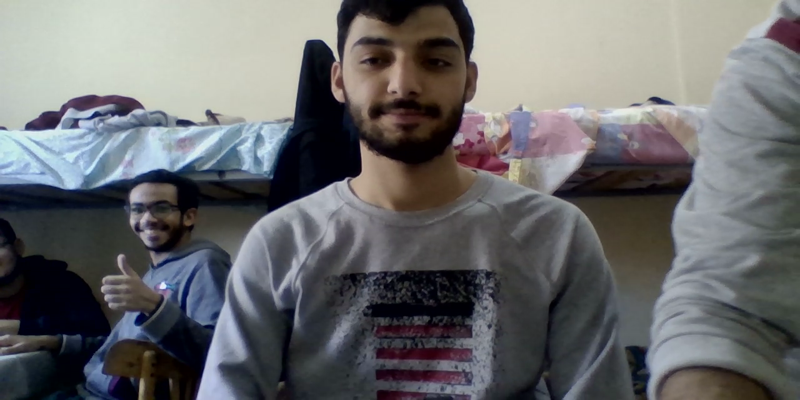

In [6]:
# Load the video
video_path = 'Model/test/WIN_20240301_15_57_57_Pro.mp4'
cap = cv2.VideoCapture(video_path)

# Display the video frame by frame
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Convert the frame to RGB
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Display the frame in the notebook
    clear_output(wait=True)
    display(Image.fromarray(frame_rgb).resize((800, 400)))

cap.release()

In [4]:
cd ..

E:\project_material


C:\Users\20155\anaconda3\envs\GP\lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


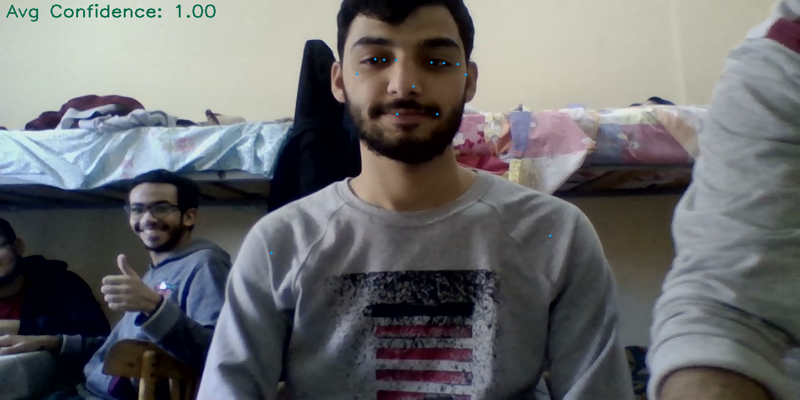

Video processing complete.


In [7]:
# Function to draw keypoints and average confidence on an image
def draw_keypoints(image, keypoints, confidences, threshold=0.5):
    avg_confidence = np.mean([c for c in confidences if c > threshold])
    for i, (point, confidence) in enumerate(zip(keypoints, confidences)):
        if confidence > threshold:
            x, y = int(point[0] * image.shape[1]), int(point[1] * image.shape[0])
            cv2.circle(image, (x, y), 2, (255, 165, 0), -1)
    cv2.putText(image, f'Avg Confidence: {avg_confidence:.2f}', (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (80, 110, 10), 2)
    return image

# Load the video
video_path = 'Model/test/WIN_20240301_15_57_57_Pro.mp4'
cap = cv2.VideoCapture(video_path)

# Keypoints and confidences data
data = pickle.load(open("Model/test/WIN_20240301_15_57_57_Pro.pkl", "rb"))

frame_idx = 0

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    if frame_idx < len(data['keypoints']):
        keypoints = data['keypoints'][frame_idx]
        confidences = data['confidences'][frame_idx]
        frame = draw_keypoints(frame, keypoints, confidences)

    # Convert frame to PIL image
    pil_image = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    pil_image_resized = pil_image.resize((800, 400))
    # Display the image in notebook
    clear_output(wait=True)
    display(pil_image_resized)

    frame_idx += 1

cap.release()

print("Video processing complete.")


In [ ]:
mkdir output

In [ ]:
d = {"001":"adress","002":"and","003":"anise","004":"banana","005":"berell","006":"birth certificate","007":"cinnamon","008":"coffee","009":"cold","010":"deaf","011":"doing","012":"drink","013":"fenugreek","014":"fine","015":"glass","016":"hello","017":"help","018":"hot","019":"How are you","020":"How much","021":"in","022":"juice","023":"lemon","024":"mango","025":"me","026":"milk","027":"mint","028":"money","029":"my","030":"name","031":"need","032":"nescafe","033":"new","034":"no","035":"number","036":"ok","037":"on","038":"or","039":"orange","040":"pepsi","041":"problem","042":"question","043":"Roselle","044":"spoon","045":"strawberry","046":"tea","047":"Thank god","048":"wait","049":"water","050":"what","051":"yes","052":"you","053":"your","054":"Your health is fine"}

In [ ]:
swapped_dict = {value: key for key, value in d.items()}

print(swapped_dict)

In [ ]:
data = "/kaggle/input/holistic/holistic_poses/holistic_poses"
for word in os.listdir(data):
    id = swapped_dict.get(word)
    if id:
        print(word,id)
        i=0
        for pos in os.listdir(os.path.join(data,word)):
            if i<=70:
                shutil.copy(os.path.join(data,word,pos),"output/"+id+"_001_0"+str(i)+".pkl")
                i+=1
            elif i <90:
                shutil.copy(os.path.join(data,word,pos),"output/"+id+"_009_0"+str(i)+".pkl")
                i+=1
            else:
                shutil.copy(os.path.join(data,word,pos),"output/"+id+"_010_0"+str(i)+".pkl")
                i+=1
    else:
        continue

In [ ]:
def init_model():
    !pip install openhands
    !rm /kaggle/working/OpenHands/openhands/models/ssl/dpc_rnn.py
    !cp /kaggle/input/holistic/dpc_rnn.py /kaggle/working/OpenHands/openhands/models/ssl/
    !rm /kaggle/working/OpenHands/openhands/core/exp_utils.py
    !cp /kaggle/input/holistic/exp_utils.py /kaggle/working/OpenHands/openhands/core/
    !rm /kaggle/working/OpenHands/openhands/apis/classification_model.py
    !cp /kaggle/input/test-data/classification_model.py /kaggle/working/OpenHands/openhands/apis/
    !rm /kaggle/working/OpenHands/openhands/apis/inference.py
    !cp /kaggle/input/test-data/inference.py /kaggle/working/OpenHands/openhands/apis/
    %cd OpenHands/
    !python setup.py install
    %cd ..

In [ ]:
!pip install git+https://github.com/PytorchLightning/lightning-bolts.git@master --upgrade
!git clone https://github.com/AI4Bharat/OpenHands.git
init_model()
init_model()

In [2]:
cd ..

E:\project_material


C:\Users\20155\anaconda3\envs\GP\lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [4]:
import openhands
print(openhands.__version__)

0.1.4.2


In [ ]:
from omegaconf import OmegaConf
from openhands.apis.classification_model import ClassificationModel
from openhands.core.exp_utils import get_trainer

cfg = OmegaConf.load("/kaggle/input/test-data/decoupled_gcn.yaml")
trainer = get_trainer(cfg)

model = ClassificationModel(cfg=cfg, trainer=trainer)
model.init_from_checkpoint_if_available()
model.fit()

In [5]:
w_b = pd.read_csv("w_b.csv")

In [6]:
w_b.head()

,epoch,treasured-donkey-13 - _step,treasured-donkey-13 - _step__MIN,treasured-donkey-13 - _step__MAX,treasured-donkey-13 - val_acc,treasured-donkey-13 - val_acc__MIN,treasured-donkey-13 - val_acc__MAX,treasured-donkey-13 - train_acc,treasured-donkey-13 - train_acc__MIN,treasured-donkey-13 - train_acc__MAX
0,0,0.5,0,1,0.038462,0.038462,0.038462,0.038571,0.038571,0.038571
1,1,3.5,3,4,0.102564,0.102564,0.102564,0.061429,0.061429,0.061429
2,2,6.5,6,7,0.098291,0.098291,0.098291,0.119048,0.119048,0.119048
3,3,9.5,9,10,0.264957,0.264957,0.264957,0.194286,0.194286,0.194286
4,4,12.5,12,13,0.314103,0.314103,0.314103,0.294762,0.294762,0.294762


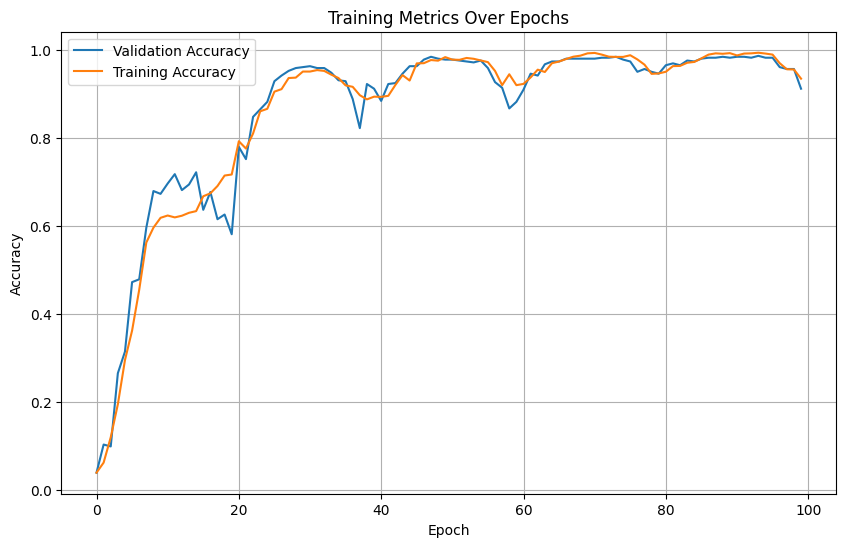

In [13]:
# Data
epoch = w_b["epoch"]
val_acc = w_b["treasured-donkey-13 - val_acc"]
train_acc = w_b["treasured-donkey-13 - train_acc"]

# Plot
plt.figure(figsize=(10, 6))
plt.plot(epoch, val_acc, label='Validation Accuracy')
plt.plot(epoch, train_acc, label='Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Metrics Over Epochs')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
!zip best_model.zip /kaggle/working/experiments/lsa64/sl_gcn/epoch=47-step=1776.ckpt

In [ ]:
from IPython.display import FileLink
FileLink(r'best_model.zip')

In [33]:
from omegaconf import OmegaConf
from openhands.apis.inference import InferenceModel
import openhands

cfg = OmegaConf.load("Model/decoupled_gcn.yaml")
model = InferenceModel(cfg=cfg)
model.init_from_checkpoint_if_available()
#//////////////////////////
#cfg.data.test_pipeline.dataset.root_dir='Model/temp/'

if cfg.data.test_pipeline.dataset.inference_mode:
   pred = model.test_inference()
else:
    model.compute_test_accuracy()

Found 53 classes in test splits
Loading checkpoint from: E:/project_material/Model/epoch91.ckpt
Thank god:	Model/test\01_0001_(10_03_21_20_37_17)_c.pkl
Thank god:	Model/test\01_0002_(10_03_21_20_53_42)_c.pkl
help:	Model/test\VID-20240228-WA0009.pkl
birth certificate:	Model/test\VID-20240228-WA0011.pkl
How much:	Model/test\VID20230309141046.pkl
adress:	Model/test\WIN_20240301_15_47_18_Pro.pkl
How much:	Model/test\WIN_20240301_15_57_57_Pro.pkl
Avg time per iteration: 944.000244140625 ms


In [33]:
test = model.datamodule.test_dataloader()

In [34]:
for batch in test:
    #print(batch)
    y_hat = model.model(batch["frames"].to(model._device)).cpu()

In [19]:
batch["frames"].shape

torch.Size([1, 2, 51, 27])

In [36]:
batch['frames']

tensor([[[[ 0.0737,  0.1497, -0.0366,  ..., -0.5976, -0.6392, -0.7128],
          [ 0.0945,  0.1733, -0.0133,  ..., -0.6028, -0.6341, -0.7183],
          [ 0.1001,  0.1784, -0.0081,  ..., -0.6030, -0.6355, -0.7174],
          ...,
          [ 0.0777,  0.1429, -0.0431,  ..., -0.6037, -0.6380, -0.7199],
          [ 0.0746,  0.1424, -0.0454,  ..., -0.6048, -0.6365, -0.7191],
          [ 0.0716,  0.1421, -0.0462,  ..., -0.6036, -0.6364, -0.7182]],

         [[-1.1639, -1.2537, -1.3064,  ...,  3.0546,  2.5589,  3.0293],
          [-1.1542, -1.2476, -1.3029,  ...,  3.0469,  2.5435,  3.0134],
          [-1.1520, -1.2464, -1.3032,  ...,  3.0507,  2.5543,  3.0189],
          ...,
          [-1.2069, -1.3123, -1.3549,  ...,  3.0517,  2.5540,  3.0243],
          [-1.2003, -1.3081, -1.3500,  ...,  3.0480,  2.5530,  3.0240],
          [-1.1922, -1.3005, -1.3462,  ...,  3.0433,  2.5551,  3.0211]]]])

In [15]:
y_hat

tensor([[ 13682.3457,   9827.1025, -26083.1660, -52501.5195,   2342.2351,
         -23558.1113, -13050.3369, -26506.0488, -16250.1113, -21476.1094,
         -22110.6172,   2873.8848,  -6034.3730,  10180.9268,  26240.8105,
         -36044.9922,   8960.6465,  -8588.3242,   8133.6069,   6503.3447,
         -27350.2051, -35932.2070, -12667.6592,  20698.7324,  10890.6084,
          35746.1797, -33995.5430,   4251.3223,  -3955.1030, -19610.8828,
         -16687.8984,   3055.6301,  26871.0918,   -867.8397, -11349.2559,
         -18522.0527,  13971.2090, -41093.9180,  14569.3857, -50541.8516,
          -4083.6160,  26483.2559, -39371.5273, -58638.1172,  21038.7695,
           7696.6470, -20811.8125, -10146.0566,   7174.6421,  14863.0879,
          18106.8906, -14407.6240, -21245.3379]], grad_fn=<AddmmBackward0>)

In [5]:
test_file = pickle.load(open("E:/project_material/holistic_poses/orange/VID20230318140117.pkl", "rb"))

In [6]:
test_file

{'keypoints': array([[[ 0.48613936,  0.22382545, -0.44824925],
         [ 0.49964088,  0.19175172, -0.42368919],
         [ 0.50843215,  0.19320655, -0.42410153],
         ...,
         [ 0.        ,  0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        ]],
 
        [[ 0.48618633,  0.22412987, -0.42105323],
         [ 0.49950576,  0.19235536, -0.39930671],
         [ 0.508448  ,  0.19405003, -0.39974433],
         ...,
         [ 0.3161827 ,  1.03529596, -0.01588706],
         [ 0.3194496 ,  1.05106366, -0.01401751],
         [ 0.32261121,  1.05878186, -0.01225335]],
 
        [[ 0.48565221,  0.22455169, -0.4158805 ],
         [ 0.4982709 ,  0.19297303, -0.39146656],
         [ 0.50777942,  0.19439942, -0.39192513],
         ...,
         [ 0.3200078 ,  0.95389301, -0.02021083],
         [ 0.32141525,  0.97357512, -0.023423  ],
         [ 0.32429406,  0.99078721, -0.02517118]],
 
        ...,
 
        [[ 0.48347577

In [40]:
my_data = model.datamodule.my_test(test_file)

In [30]:
batch["frames"]

tensor([[[[ 0.0737,  0.1497, -0.0366,  ..., -0.5976, -0.6392, -0.7128],
          [ 0.0945,  0.1733, -0.0133,  ..., -0.6028, -0.6341, -0.7183],
          [ 0.1001,  0.1784, -0.0081,  ..., -0.6030, -0.6355, -0.7174],
          ...,
          [ 0.0777,  0.1429, -0.0431,  ..., -0.6037, -0.6380, -0.7199],
          [ 0.0746,  0.1424, -0.0454,  ..., -0.6048, -0.6365, -0.7191],
          [ 0.0716,  0.1421, -0.0462,  ..., -0.6036, -0.6364, -0.7182]],

         [[-1.1639, -1.2537, -1.3064,  ...,  3.0546,  2.5589,  3.0293],
          [-1.1542, -1.2476, -1.3029,  ...,  3.0469,  2.5435,  3.0134],
          [-1.1520, -1.2464, -1.3032,  ...,  3.0507,  2.5543,  3.0189],
          ...,
          [-1.2069, -1.3123, -1.3549,  ...,  3.0517,  2.5540,  3.0243],
          [-1.2003, -1.3081, -1.3500,  ...,  3.0480,  2.5530,  3.0240],
          [-1.1922, -1.3005, -1.3462,  ...,  3.0433,  2.5551,  3.0211]]]])

In [41]:
my_data['frames']

tensor([[[ 0.0737,  0.1497, -0.0366,  ..., -0.5976, -0.6392, -0.7128],
         [ 0.0945,  0.1733, -0.0133,  ..., -0.6028, -0.6341, -0.7183],
         [ 0.1001,  0.1784, -0.0081,  ..., -0.6030, -0.6355, -0.7174],
         ...,
         [ 0.0777,  0.1429, -0.0431,  ..., -0.6037, -0.6380, -0.7199],
         [ 0.0746,  0.1424, -0.0454,  ..., -0.6048, -0.6365, -0.7191],
         [ 0.0716,  0.1421, -0.0462,  ..., -0.6036, -0.6364, -0.7182]],

        [[-1.1639, -1.2537, -1.3064,  ...,  3.0546,  2.5589,  3.0293],
         [-1.1542, -1.2476, -1.3029,  ...,  3.0469,  2.5435,  3.0134],
         [-1.1520, -1.2464, -1.3032,  ...,  3.0507,  2.5543,  3.0189],
         ...,
         [-1.2069, -1.3123, -1.3549,  ...,  3.0517,  2.5540,  3.0243],
         [-1.2003, -1.3081, -1.3500,  ...,  3.0480,  2.5530,  3.0240],
         [-1.1922, -1.3005, -1.3462,  ...,  3.0433,  2.5551,  3.0211]]])

In [42]:
my_data['frames'].shape

torch.Size([2, 51, 27])

In [43]:
new_shape = my_data['frames'].unsqueeze(0)

In [44]:
new_shape.shape

torch.Size([1, 2, 51, 27])

In [45]:
new_shape

tensor([[[[ 0.0737,  0.1497, -0.0366,  ..., -0.5976, -0.6392, -0.7128],
          [ 0.0945,  0.1733, -0.0133,  ..., -0.6028, -0.6341, -0.7183],
          [ 0.1001,  0.1784, -0.0081,  ..., -0.6030, -0.6355, -0.7174],
          ...,
          [ 0.0777,  0.1429, -0.0431,  ..., -0.6037, -0.6380, -0.7199],
          [ 0.0746,  0.1424, -0.0454,  ..., -0.6048, -0.6365, -0.7191],
          [ 0.0716,  0.1421, -0.0462,  ..., -0.6036, -0.6364, -0.7182]],

         [[-1.1639, -1.2537, -1.3064,  ...,  3.0546,  2.5589,  3.0293],
          [-1.1542, -1.2476, -1.3029,  ...,  3.0469,  2.5435,  3.0134],
          [-1.1520, -1.2464, -1.3032,  ...,  3.0507,  2.5543,  3.0189],
          ...,
          [-1.2069, -1.3123, -1.3549,  ...,  3.0517,  2.5540,  3.0243],
          [-1.2003, -1.3081, -1.3500,  ...,  3.0480,  2.5530,  3.0240],
          [-1.1922, -1.3005, -1.3462,  ...,  3.0433,  2.5551,  3.0211]]]])

In [7]:
model.my_test_inference(test_file)

'orange'